In [1]:
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFT
from dstft.loss import kurtosis_loss
from dstft.optim import scale_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.Size([1, 6636]) cuda:0 torch.float32
[0, 1484, 2637, 3272, 3633, 5429, 6636]


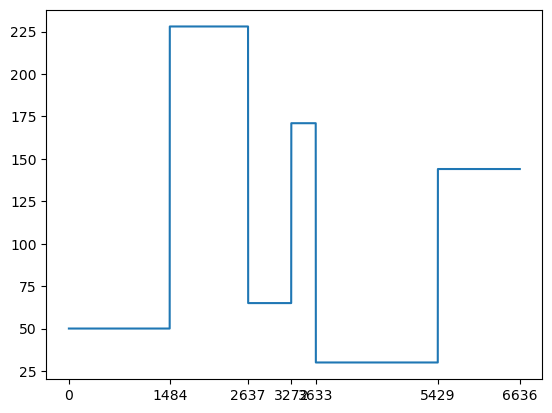

In [2]:
sr = 1e3
sizes = [1484, 1153, 635, 361, 1796, 1207]
freqs = [50, 228, 65, 171, 30, 144,]
f = freqs[0] * (torch.ones(sizes[0]) + .0 * torch.randn(sizes[0]))
for i in range(1, len(freqs)):
    f = torch.cat((f, freqs[i]  * (torch.ones(sizes[i]) + .0 * torch.randn(sizes[i]))))
f = f + 0. * torch.ones_like(f) * torch.randn_like(f)

x = torch.sin(2*pi*torch.cumsum(f, 0)/sr)
x += 0.2 * torch.randn(x.shape)
x = x[None, :].to(device)
print(x.shape, x.device, x.dtype)

mark_list = np.cumsum(sizes).tolist()
mark_list.insert(0, 0)
print(mark_list)

plt.figure()
plt.plot(f)
plt.xticks(mark_list)
plt.show()

tensor(0.9158, device='cuda:0')
tensor(106.0681, device='cuda:0')
tensor([461.5000, 500.0000, 500.0000, 500.0000, 500.0000, 500.0000, 500.0000,
        500.0000, 500.0000, 500.0000, 500.0000, 500.0000], device='cuda:0')


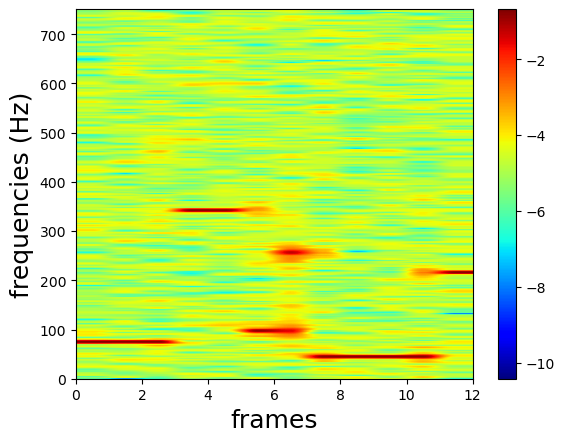

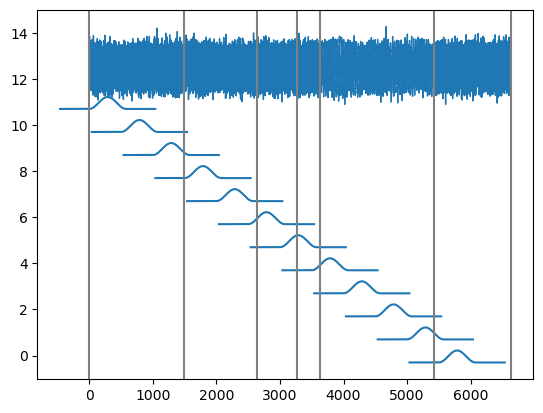

In [5]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=False, stride_requires_grad=False, win_p='tf', stride_p=None, first_frame=True)
spec, *_ = dstft(x)
dstft.print(spec, x, weights=False, bar=True, marklist=mark_list)

Time-varying window length

Epoch 00431: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00441: reducing learning rate of group 0 to 4.0000e-02.
440


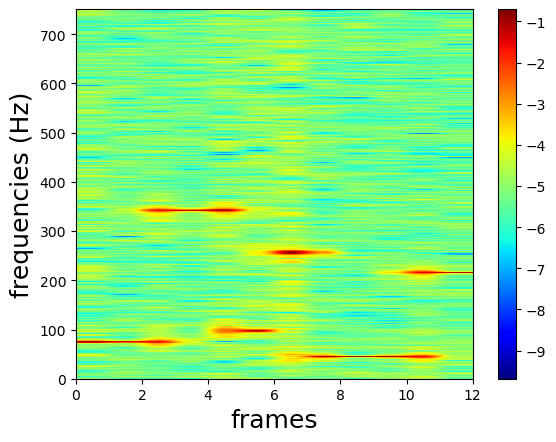

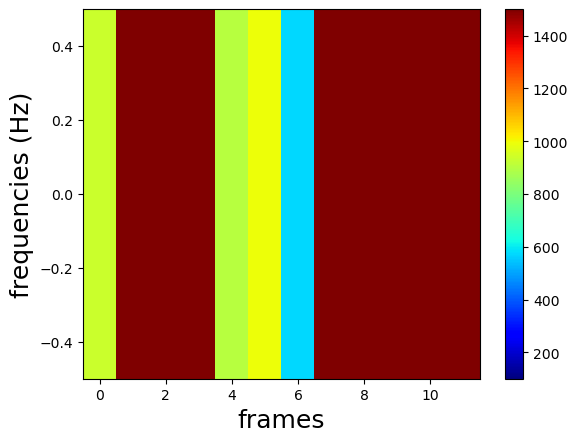

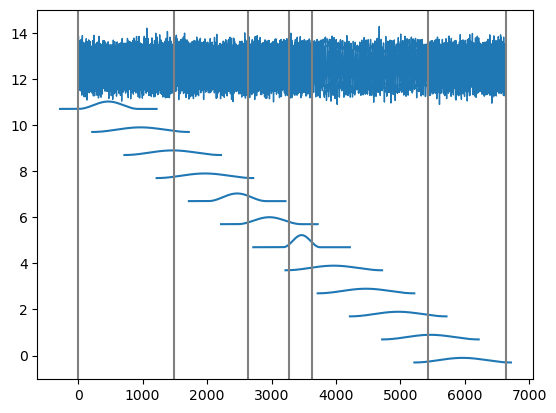

In [6]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.win_length, 'lr': 4.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Epoch 00569: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00580: reducing learning rate of group 0 to 4.0000e-02.
579


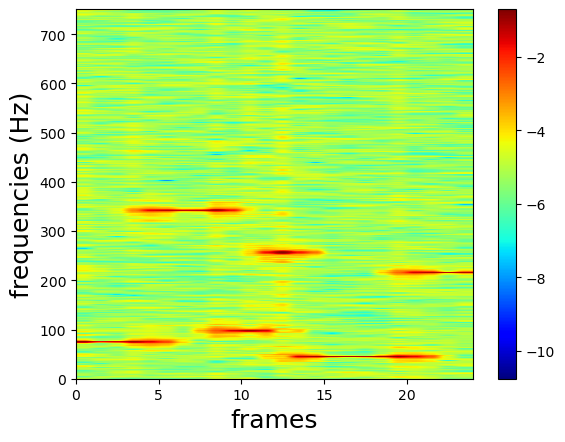

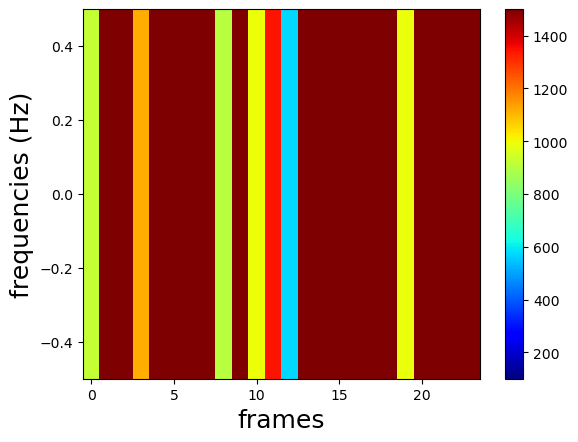

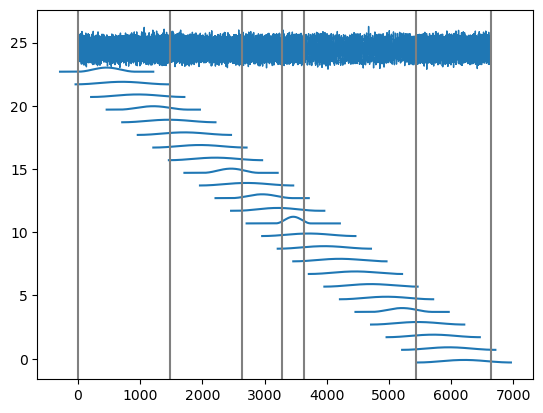

In [7]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.win_length, 'lr': 4.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()   
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

time-varying hop length

Epoch 00375: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00386: reducing learning rate of group 0 to 4.0000e-02.
385


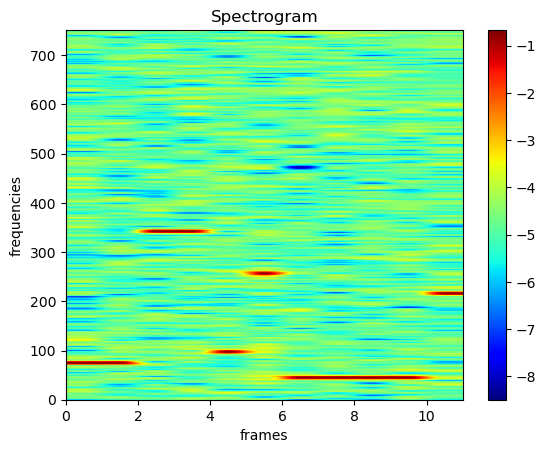

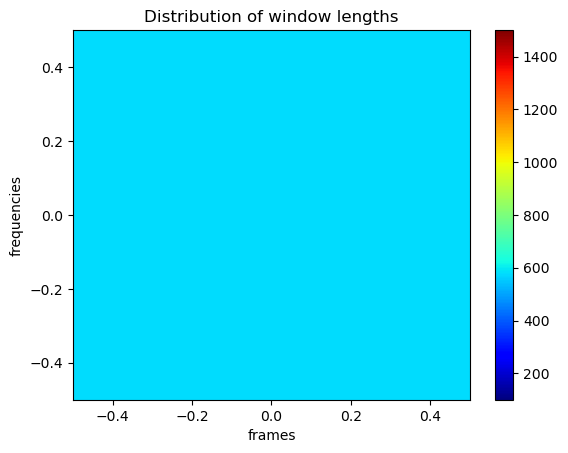

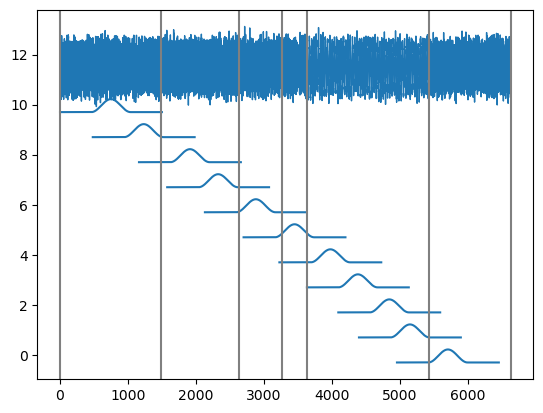

In [4]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=False, stride_requires_grad=True, win_p=None, stride_p='t', win_min=100)
params = [{'params': dstft.parameters(), 'lr': 4.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean()    
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Epoch 00486: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00497: reducing learning rate of group 0 to 4.0000e-02.
496


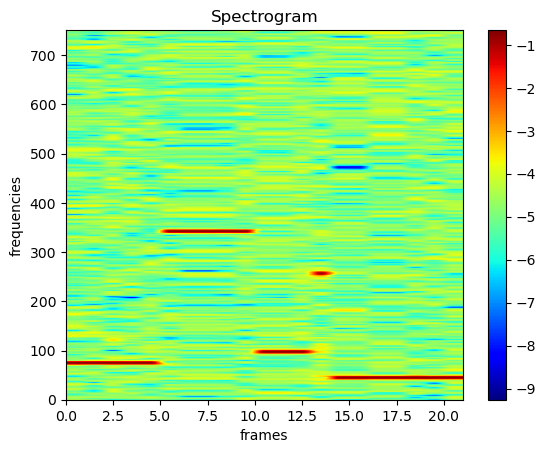

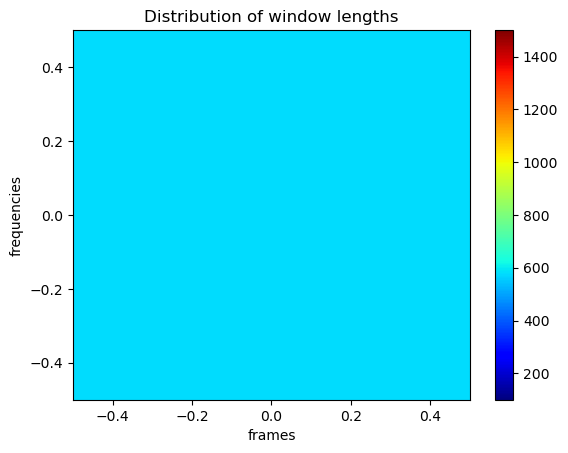

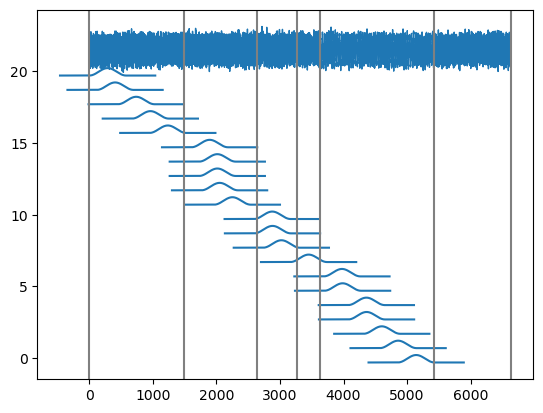

In [6]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=False, stride_requires_grad=True, win_p=None, stride_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.parameters(), 'lr': 4.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean() 
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Time-varying window and hop length

Epoch 00622: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00633: reducing learning rate of group 0 to 4.0000e-02.
632


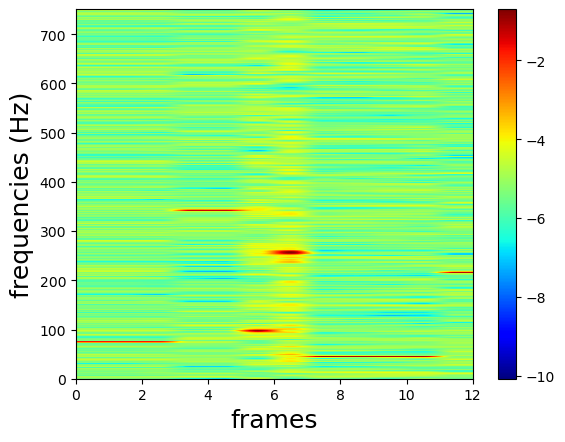

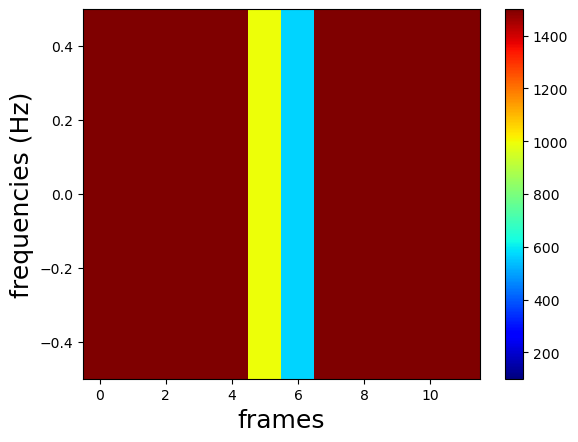

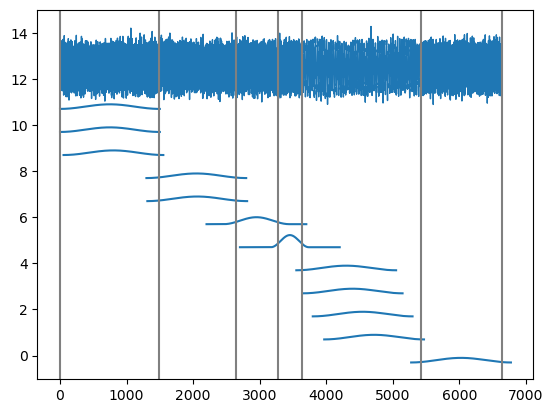

In [10]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()   
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Epoch 00711: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00722: reducing learning rate of group 0 to 4.0000e-02.
721


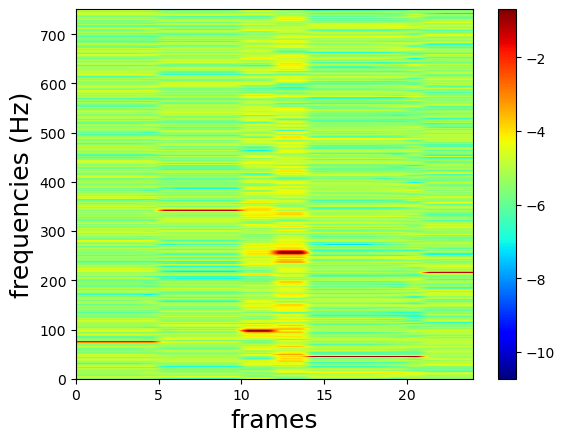

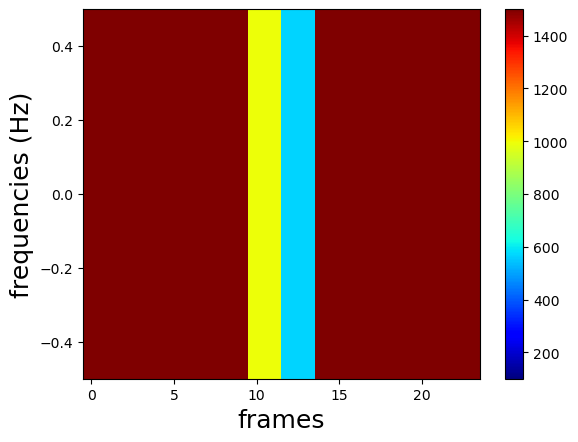

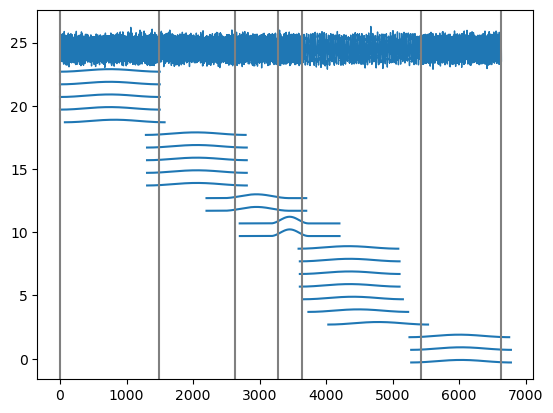

In [11]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()   
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Time-and-frequency varying window length and time-varying hop length

Epoch 00596: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00606: reducing learning rate of group 0 to 4.0000e-02.
605


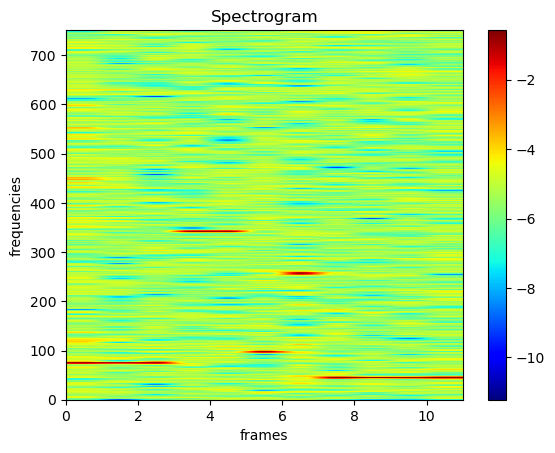

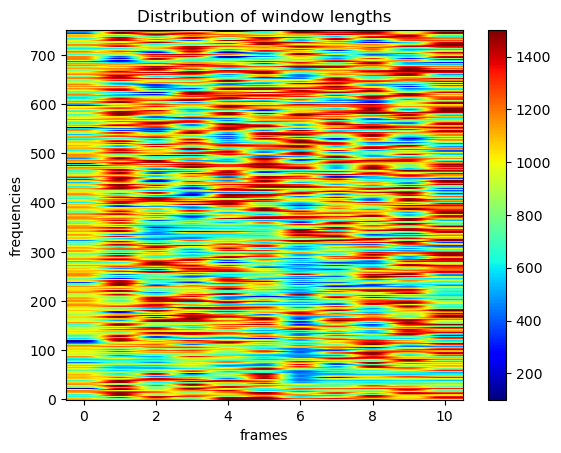

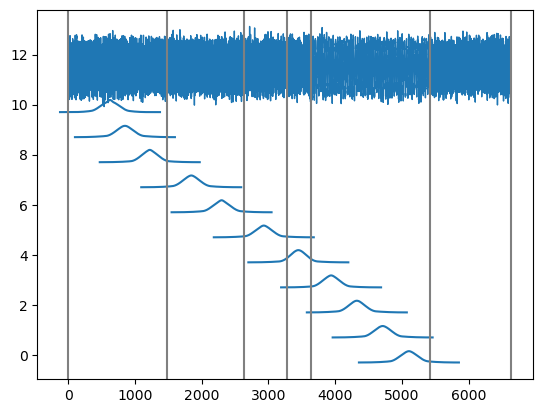

In [7]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=True, win_p='tf', stride_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(100_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Epoch 01648: reducing learning rate of group 0 to 4.0000e-01.
Epoch 01679: reducing learning rate of group 0 to 4.0000e-02.
1678


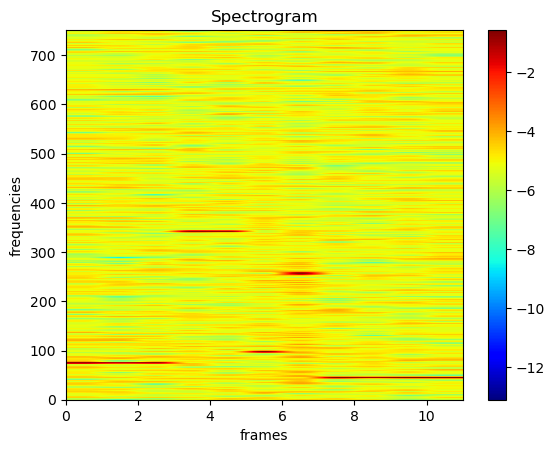

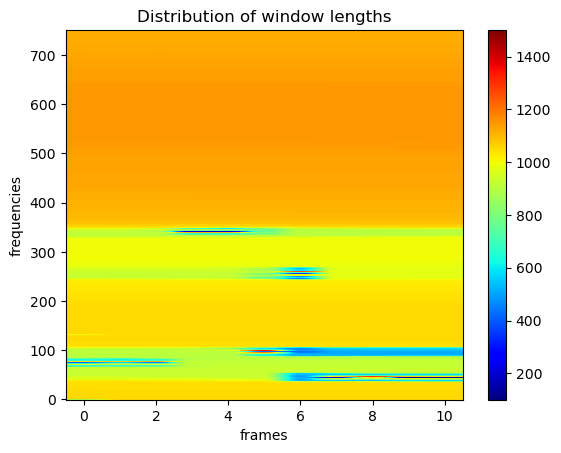

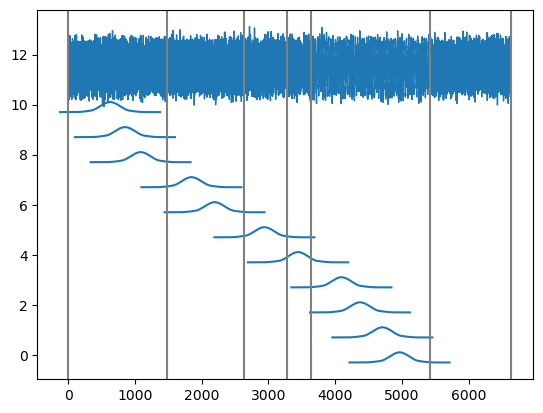

In [8]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=True, win_p='tf', stride_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(100_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean() + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()   
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Epoch 00512: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00553: reducing learning rate of group 0 to 4.0000e-02.
552


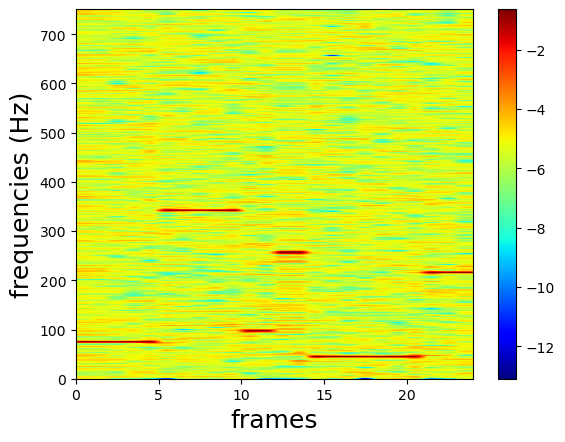

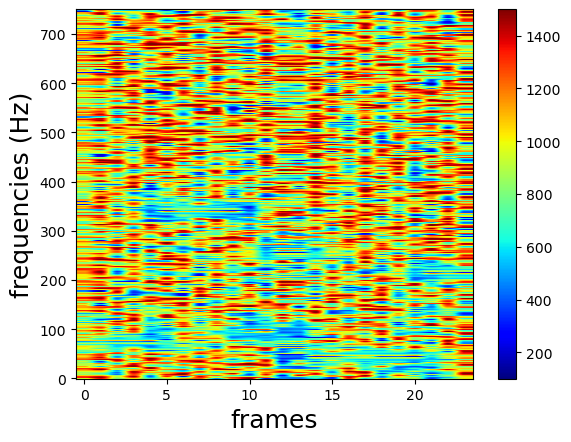

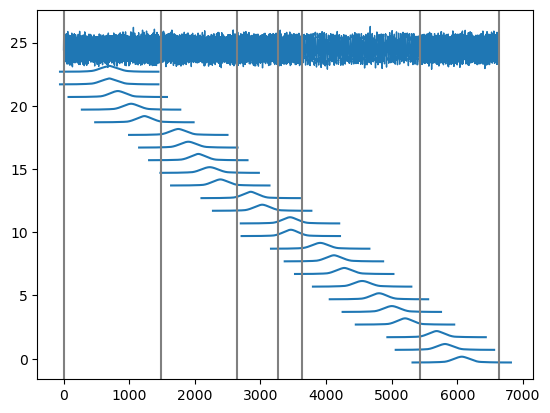

In [14]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=True, win_p='tf', stride_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Epoch 00867: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00902: reducing learning rate of group 0 to 4.0000e-02.
901


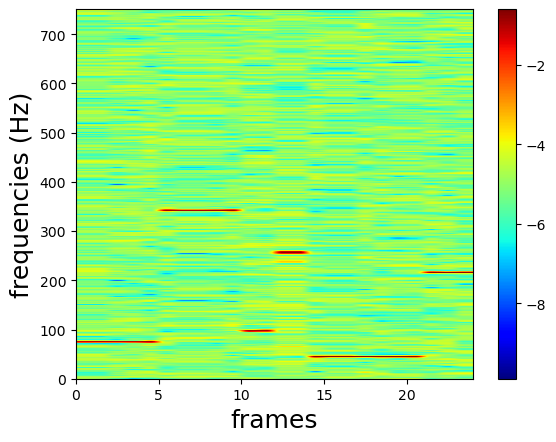

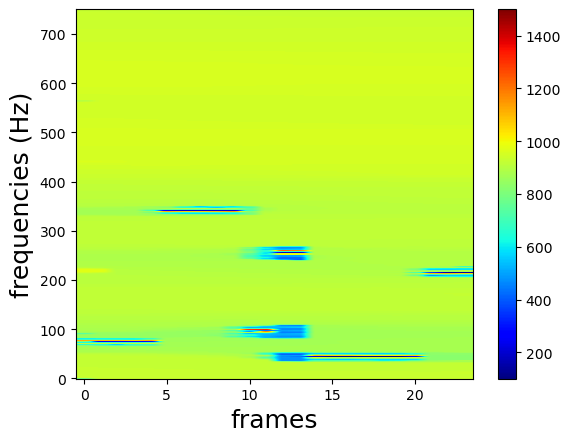

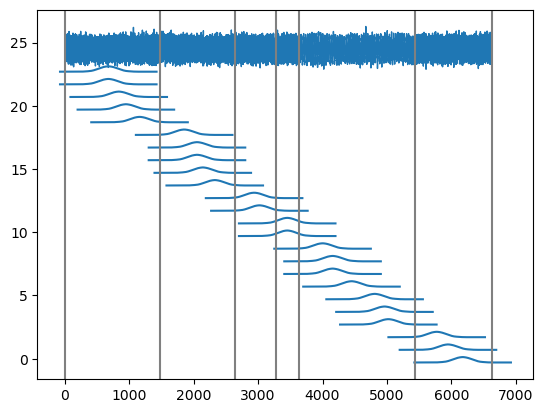

In [15]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=True, win_p='tf', stride_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean()  + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()   
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Multi objective optimization

Epoch 05697: reducing learning rate of group 0 to 2.0000e+00.
Epoch 05820: reducing learning rate of group 0 to 1.0000e+00.
Epoch 05920: reducing learning rate of group 0 to 5.0000e-01.
5919


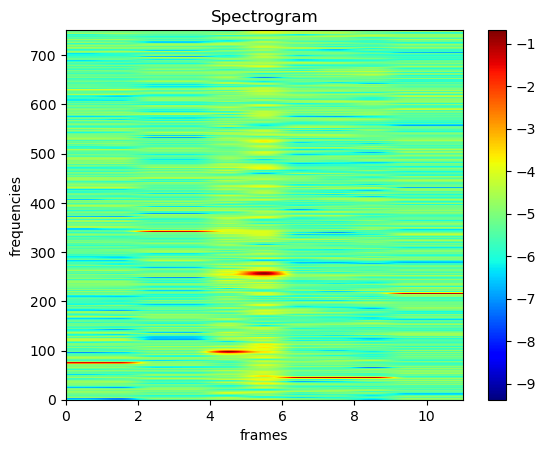

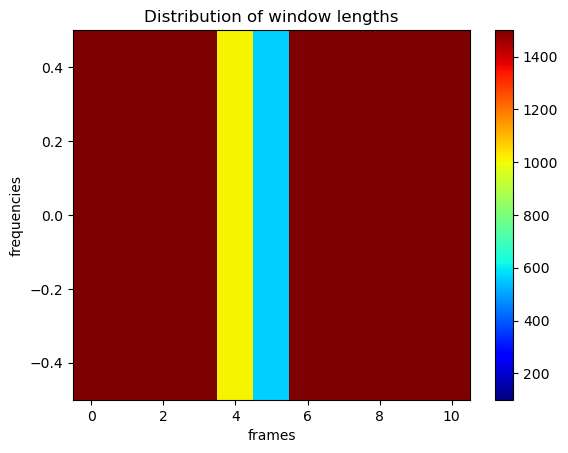

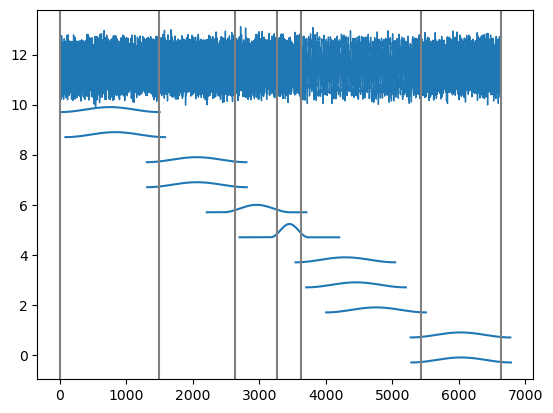

In [9]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100, first_frame=True)
params = [ {'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.5, patience=99, verbose=True)

def loss_kur(spec, dstft):
    return 1_000 * (1 / kurtosis_loss(spec)).mean()

def loss_cov(dstft):
    return 1_000 * (1 - dstft.coverage())

for epoch in range(10_000):
    scale = scale_loss(dstft, x, loss_kur, loss_cov)
    
    opt.zero_grad()    
    spec, *_ = dstft(x)
    loss1 = loss_kur(spec, dstft)
    loss2 = loss_cov(dstft)
    
    err = scale['loss1'] * loss1 + scale['loss2'] * loss2
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Epoch 05460: reducing learning rate of group 0 to 2.0000e+00.
Epoch 05570: reducing learning rate of group 0 to 1.0000e+00.
Epoch 05670: reducing learning rate of group 0 to 5.0000e-01.
5669


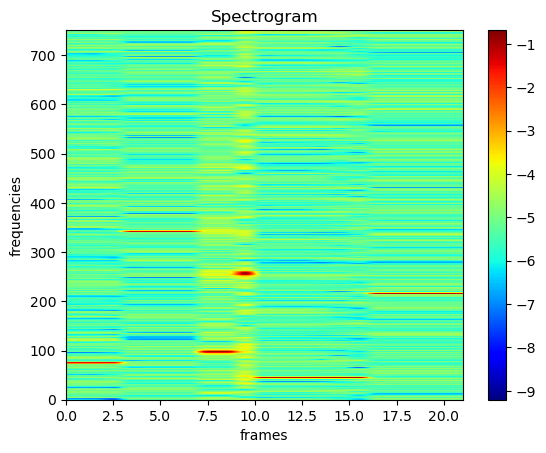

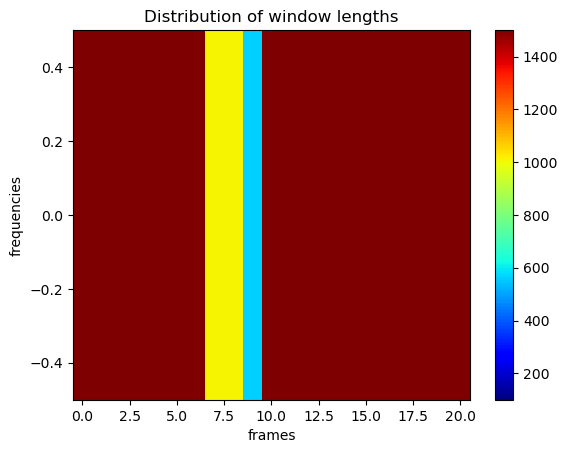

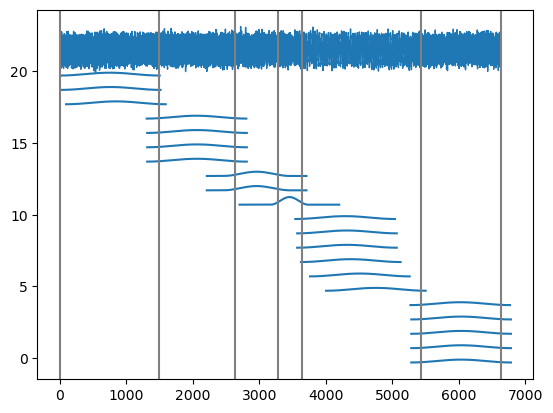

In [10]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100)
params = [ {'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.5, patience=99, verbose=True)

def loss_kur(spec, dstft):
    return 1_000 * (1 / kurtosis_loss(spec)).mean()

def loss_cov(dstft):
    return 1_000 * (1 - dstft.coverage())

for epoch in range(10_000):
    scale = scale_loss(dstft, x, loss_kur, loss_cov)
    
    opt.zero_grad()    
    spec, *_ = dstft(x)
    loss1 = loss_kur(spec, dstft)
    loss2 = loss_cov(dstft)
    
    err = scale['loss1'] * loss1 + scale['loss2'] * loss2
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)